In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

assert tf.__version__ >= "2.0.0"
tf.keras.backend.set_floatx("float32")

tf.compat.v1.set_random_seed(0) # Settings seeds so that behavior is reliable.
np.random.seed(0)

In [2]:
( x_train, _ ), ( x_test, _ ) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
x_train, x_test = np.expand_dims( x_train, axis=-1 ), np.expand_dims( x_test, axis=-1 ) # Test data is kept seperate

This loads the minst dataset from the google storage API as numpy arrays. As this is an unsuperviesed technique, we don't need the labels. 

In [3]:
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, Flatten
    
class Encoder_Model(tf.keras.Model):
    def __init__(self,input_shape, target_shape):
        super().__init__()
        after_conv_shape = (
                input_shape[0]-9, 
                input_shape[1]-9,
                1)
        
        self.encode_layers = [
            Conv2D(8,(4,4)),
            Conv2D(64,(4,4)),
            Conv2D(128,(4,4)),
            Dense(128),
            Flatten(),
            Dense(np.prod(after_conv_shape)),
            Dense(np.prod(target_shape))
        ]
        
    def call(self,x):
        for layer in self.encode_layers:
            x = layer(x)
        return x

The endocer model takes the image and produces a single vector of values, given by the target shape. The larger this value is, the more information can be passeded between the two models and the final image looks better. This will be show later. 

In [4]:
class Decoder_Model(tf.keras.Model):
    def __init__(self,input_shape, target_shape):
        super().__init__()
        before_conv_shape = (
                target_shape[0]-9, 
                target_shape[1]-9,
                1)
        
        self.decode_layers = [
            Dense(np.prod(input_shape)),
            Dense(np.prod(before_conv_shape)),
            Reshape(before_conv_shape),
            Dense(128),
            Conv2DTranspose(128,(4,4)),
            Conv2DTranspose(64,(4,4)),
            Conv2DTranspose(8,(4,4)),
            Dense(1)
        ]
        
    def call(self,x):
        for layer in self.decode_layers:
            x = layer(x)
        return x

The decoder model takes that vector and turns it back into the origional image. My implementation does this by having a similar model structure to the encoder, but in reverse. 

In [5]:
class Auto_Encoder_Model(tf.keras.Model):
    def __init__(self,input_shape, bottle_neck):
        super().__init__()
        self.encoder = Encoder_Model(input_shape, bottle_neck)
        self.decoder = Decoder_Model(bottle_neck, input_shape)
    
    def call(self,x):
        x = self.encoder(x/255) # Normalises values to [0,1]
        x = self.decoder(x)*255
        return x
    
    def get_models(self):
        return self.encoder, self.decoder

This class feeds the output of the encoder into the decoder so that the models can be trained together more easily but then taken invididualy later.

In [6]:
model = Auto_Encoder_Model((28,28,1),(96)) # Using input of a 28x28 image and a bottle neck of 96 values
model.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.0005),
    loss = tf.keras.losses.mse) # MSE loss is used as it is a regression task.

In [7]:
_ = model.fit(x_train,x_train,epochs=20,batch_size=1024)

Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 26s 432us/sample - loss: 4285.4977
Epoch 2/20
60000/60000 [==============================] - 21s 357us/sample - loss: 1419.3352
Epoch 3/20
60000/60000 [==============================] - 21s 358us/sample - loss: 1115.0620
Epoch 4/20
60000/60000 [==============================] - 22s 359us/sample - loss: 899.0693
Epoch 5/20
60000/60000 [==============================] - 22s 360us/sample - loss: 812.4402
Epoch 6/20
60000/60000 [==============================] - 22s 360us/sample - loss: 763.8034
Epoch 7/20
60000/60000 [==============================] - 22s 360us/sample - loss: 696.0139
Epoch 8/20
60000/60000 [==============================] - 22s 361us/sample - loss: 678.9997
Epoch 9/20
60000/60000 [==============================] - 22s 360us/sample - loss: 634.4419
Epoch 10/20
60000/60000 [==============================] - 22s 361us/sample - loss: 632.6516
Epoch 11/20
60000/60000 [============================

The same data is passed to both the x and y arguemnts of the fit function so the models loss is minimised when the image can be reproduced accurately. 

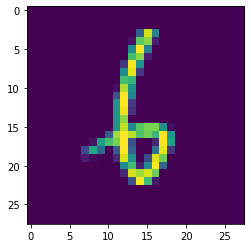

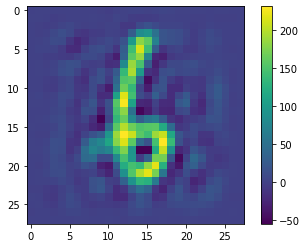

In [8]:
index = np.random.randint(x_test.shape[0])
image = x_test[index]
result = model(np.expand_dims(image,0))[0]

plt.imshow(np.squeeze(image))
plt.show()
plt.imshow(np.squeeze(result))
plt.colorbar()
plt.show()

This sample shows that the model works as expected, reproducing the image. 

Input Images


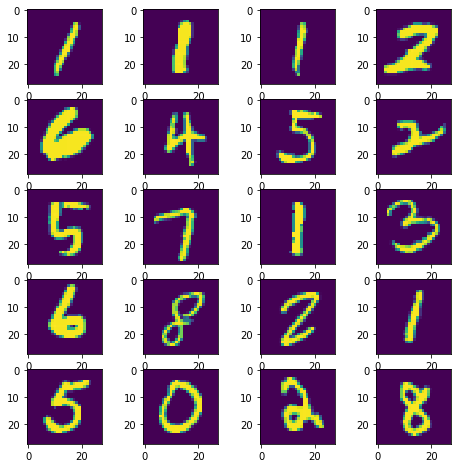

Reproduced Images


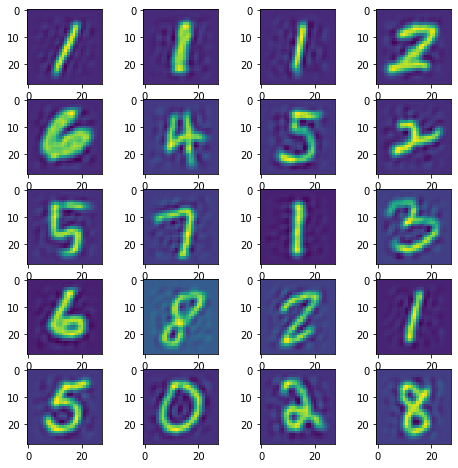

In [9]:
def show_images(images):
    # Shows 20
    fig=plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    for i in range(columns*rows):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(images[i])
    plt.show()

indicies = np.random.randint(x_test.shape[0],size=20)
sample = np.take(x_test,indicies,axis=0)
predictions = model(sample)
sample, predictions = np.squeeze(sample), np.squeeze(predictions)

print("Input Images")
show_images(sample)

print("Reproduced Images")
show_images(predictions)

The model is pretty good as you can make out the numbers easily but there is some noise in the background. If the bottle neck is larger then the predictions become even better. This could possibly be fixed by something like a filter. The effects of a simple implementation can be seen below.


Reproduced images


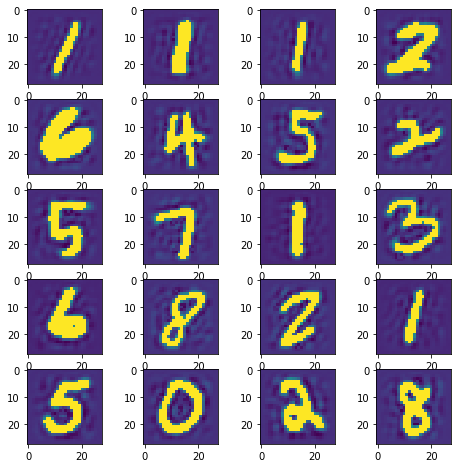

In [10]:
mean = tf.reduce_mean(predictions).numpy()
sx = tf.math.reduce_std(predictions).numpy()
low_pass = np.vectorize(lambda x: 0 if x < (mean-sx) else (255 if x > (mean+sx) else x))
filtered = low_pass(predictions)
print("Reproduced images")
show_images(filtered)

The digits are now much clearer. 

The digits can also be made clearer by increasing the bottle neck size of the model.

In [12]:
model2 = Auto_Encoder_Model((28,28,1),(256)) # Much larger bottle neck
model2.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.0001),
    loss = tf.keras.losses.mse) 
_ = model2.fit(x_train,x_train,epochs=20,batch_size=1024)

Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 36s 594us/sample - loss: 2381.5483
Epoch 2/20
60000/60000 [==============================] - 35s 581us/sample - loss: 957.6416
Epoch 3/20
60000/60000 [==============================] - 35s 580us/sample - loss: 679.4800
Epoch 4/20
60000/60000 [==============================] - 35s 580us/sample - loss: 556.4767
Epoch 5/20
60000/60000 [==============================] - 35s 577us/sample - loss: 493.8905
Epoch 6/20
60000/60000 [==============================] - 35s 577us/sample - loss: 446.5293
Epoch 7/20
60000/60000 [==============================] - 35s 577us/sample - loss: 417.0327
Epoch 8/20
60000/60000 [==============================] - 35s 577us/sample - loss: 392.3812
Epoch 9/20
60000/60000 [==============================] - 35s 577us/sample - loss: 374.8513
Epoch 10/20
60000/60000 [==============================] - 35s 577us/sample - loss: 379.1547
Epoch 11/20
60000/60000 [==============================

The results from this model can be seen below.

Input Images


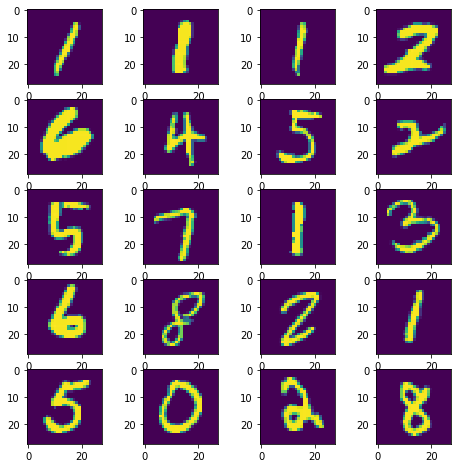

Reproduced Images


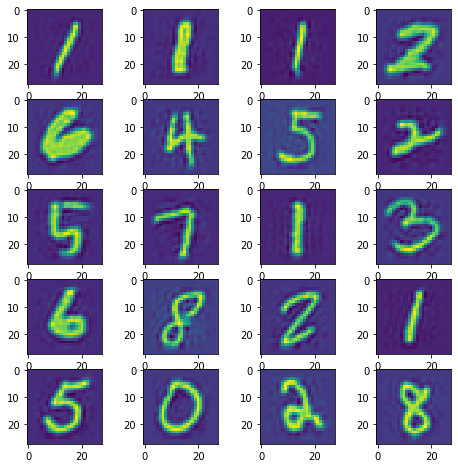

In [13]:
sample = np.take(x_test,indicies,axis=0)
predictions2 = model2(sample)
sample, predictions2 = np.squeeze(sample), np.squeeze(predictions2)

print("Input Images")
show_images(sample)

print("Reproduced Images")
show_images(predictions2)

The images look better and we can evaluate the loss function so see how much better.

In [15]:
print("Bottle neck of 96:  loss is {:.3f}".format(model.evaluate(x_test,x_test,1024,verbose=0)))
print("Bottle neck of 256: loss is {:.3f}".format(model2.evaluate(x_test,x_test,1024,verbose=0)))

Bottle neck of 96:  loss is 505.983
Bottle neck of 256: loss is 328.413


The loss is much lower so we know that it performs better overall. 